In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# :https://claude.ai/chat/d2308f5c-b8e1-49de-8e54-05d92dc8017b
# https://grok.com/c/29b64892-22ce-4423-b6c5-26e01ed4bef6
# https://chatgpt.com/c/68d13b9b-5790-832b-aad0-858310b6b5dd

In [ ]:
# Loading the data
df = pd.read_csv('cleaned_room_occupay.csv')
df.head()

,Temperature,Humidity,CO2,Occupancy,minute,hour,day
0,23.70,26.272,749.20,1,19,14,2
1,23.72,26.290,760.40,1,19,14,2
2,23.73,26.230,769.67,1,21,14,2
3,23.72,26.125,774.75,1,22,14,2
4,23.75,26.200,779.00,1,23,14,2


In [ ]:
df.shape

(20560, 7)

In [ ]:
# Making label and features
X = df.drop('Occupancy', axis=1).values
y = df['Occupancy'].values


# Calculating class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict



n = len(X)
train_size=0.7
val_size=0.15

train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))
X_train = X[:train_end]
y_train = y[:train_end]
    
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
    
X_test = X[val_end:]
y_test = y[val_end:]


scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)


Shape of training data: (14391, 6) (14391,)
Shape of validation data: (3085, 6) (3085,)
Shape of test data: (3084, 6) (3084,)


In [ ]:
# Creating sequences:
def create_windows(X, y, window_size=60, stride=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size + 1, stride):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = create_windows(X_train, y_train)
X_val, y_val = create_windows(X_val, y_val)
X_test, y_test = create_windows(X_test, y_test)

print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)

Training sequences shape: (14332, 60, 6)
Training class shape: (14332,)


In [ ]:
num_0 = (y_train == 0).sum()
num_1 = (y_train == 1).sum()
total = len(y_train)
weight_for_0 = total / (2 * num_0)
weight_for_1 = total / (2 * num_1)
class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)

Class weights: {0: 0.6625982431807674, 1: 2.0375319874893374}


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same',
           input_shape=(60, X_train.shape[2])),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       245,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,113 (1.17 MB)

 Trainable params: 305,729 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, 
    epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stop, reduce_lr],
    validation_data=(X_val, y_val),verbose=2)

Epoch 1/20
224/224 - 3s - 14ms/step - accuracy: 0.8905 - loss: 0.2535 - precision: 0.7111 - val_accuracy: 0.6603 - val_loss: 0.6259 - val_precision: 0.3637 - learning_rate: 0.0010
Epoch 2/20
224/224 - 1s - 6ms/step - accuracy: 0.9286 - loss: 0.1581 - precision: 0.7897 - val_accuracy: 0.9427 - val_loss: 0.1417 - val_precision: 0.8050 - learning_rate: 0.0010
Epoch 3/20
224/224 - 1s - 6ms/step - accuracy: 0.9417 - loss: 0.1266 - precision: 0.8206 - val_accuracy: 0.9344 - val_loss: 0.1570 - val_precision: 0.7764 - learning_rate: 0.0010
Epoch 4/20
224/224 - 1s - 6ms/step - accuracy: 0.9482 - loss: 0.1121 - precision: 0.8382 - val_accuracy: 0.8989 - val_loss: 0.2226 - val_precision: 0.6691 - learning_rate: 0.0010
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
224/224 - 1s - 6ms/step - accuracy: 0.9496 - loss: 0.1178 - precision: 0.8438 - val_accuracy: 0.9509 - val_loss: 0.1436 - val_precision: 0.9380 - learning_rate: 0.0010
Epoch 6/20
224/224 - 1s - 6

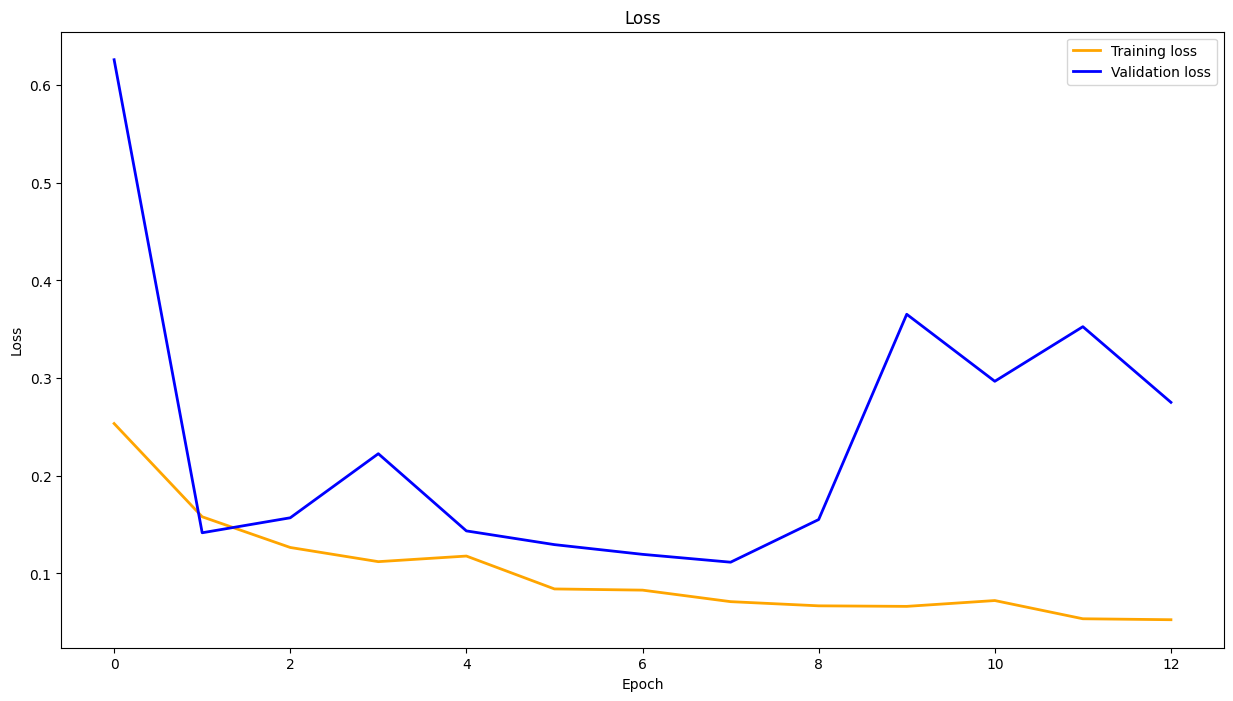

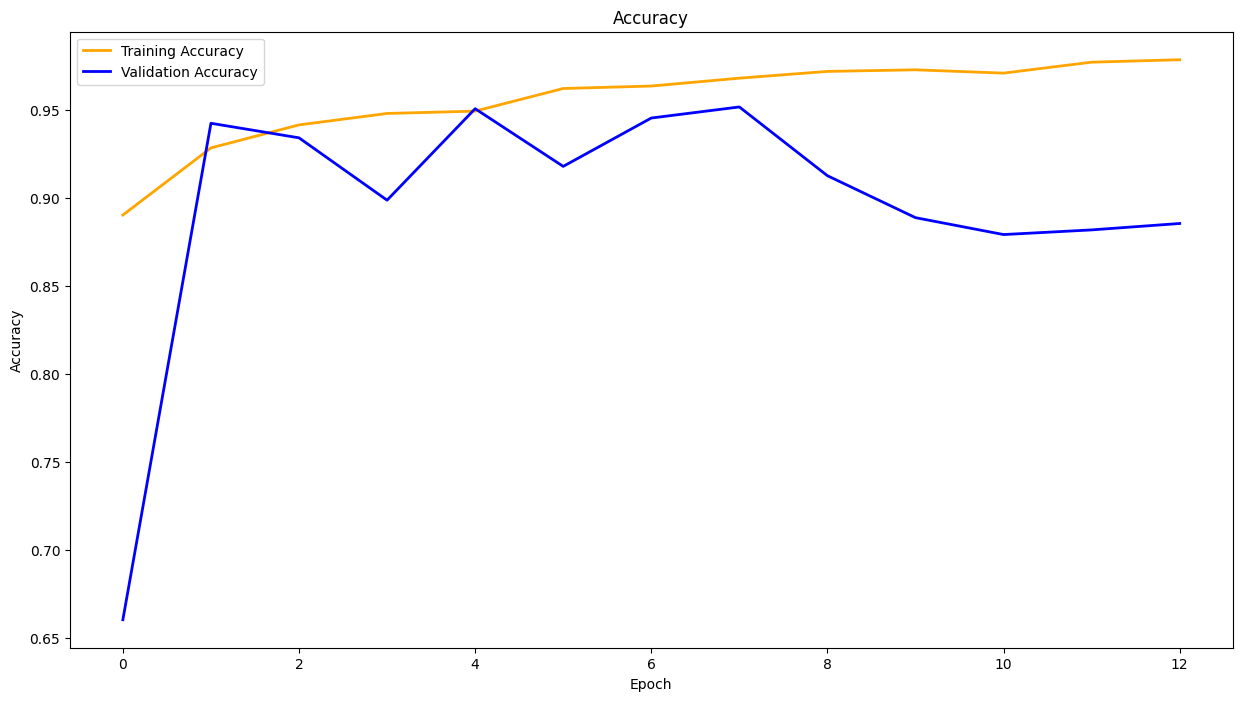

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training Accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


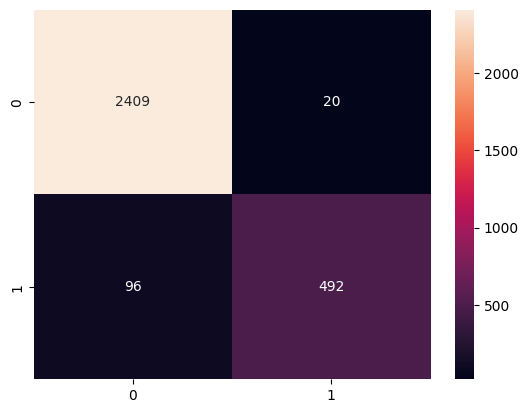

In [ ]:
# Predict on test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2429
           1       0.96      0.84      0.89       588

    accuracy                           0.96      3017
   macro avg       0.96      0.91      0.94      3017
weighted avg       0.96      0.96      0.96      3017

